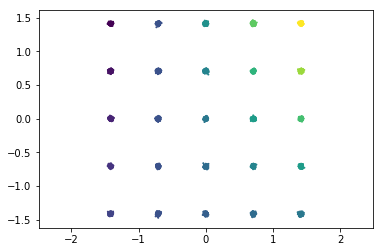

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
import numpy as np

n_samples = 10000

data = '25gaussian'

if data=='blob':
    x_org,y = datasets.make_blobs(n_samples=n_samples, random_state=8)
elif data=='moon':
    x_org,y = datasets.make_moons(n_samples=n_samples, noise=.05)
elif data=='circle':
    x_org,y = datasets.make_circles(n_samples=n_samples, factor=.5,noise=.05)
elif data=='random':
    x_org,y = np.random.random((n_samples,2)), np.random.random((n_samples,))
elif data=='25gaussian':
    x_org = []
    y = []
    for i in range(5):
        for j in range(5):
            x1 = np.random.normal(loc=i*50, scale=1, size=(n_samples//5//5))
            x2 = np.random.normal(loc=j*50, scale=1, size=(n_samples//5//5))
            x_org.append([x1,x2])
            y.append([(i-1)*j+i]*(n_samples//5//5))
    x_org = np.array(x_org).transpose(0,2,1).reshape((n_samples,2))
    x_org = (x_org - x_org.mean(keepdims=True))/x_org.std(keepdims=True)
    y = np.array(y).flatten()
elif data=='8gaussian':
    x_org = []
    y = []
    for i in range(8):
        r1 = 50*np.array(np.cos(2*np.pi/8.*float(i)))
        r2 = 50*np.array(np.sin(2*np.pi/8.*float(i)))
        x1 = np.random.normal(loc=r1, scale=1, size=(n_samples//8))
        x2 = np.random.normal(loc=r2, scale=1, size=(n_samples//8))
        x_org.append([x1,x2])
        y.append([i]*(n_samples//8))
    x_org = np.array(x_org).transpose(0,2,1).reshape((n_samples,2))
    x_org = (x_org - x_org.mean(keepdims=True))/x_org.std(keepdims=True)
    y = np.array(y).flatten()
    
xmax, xmin = x_org.max(), x_org.min()

nb_data = len(x_org)
nb_dim = x_org.shape[1]
nb_mix = 30

plt.scatter(x_org[:,0], x_org[:,1], c=y, s=1)
plt.axes().set_aspect('equal', 'datalim')

[# of data,  # of mixture, dimension]

In [2]:
def pdf_gaussian(x, mean, cov):
    shift1 = np.expand_dims((x-mean), -1)
    shift2 = np.expand_dims((x-mean), -2)
    det = np.linalg.det(cov)
    inv = np.linalg.inv(cov)
    coef = 1. / (np.sqrt(2.*np.pi))**x.shape[-1] / np.sqrt(det)
    return coef * np.exp(-0.5 * (np.matmul(x-mean,inv) * (x-mean)).sum(-1))

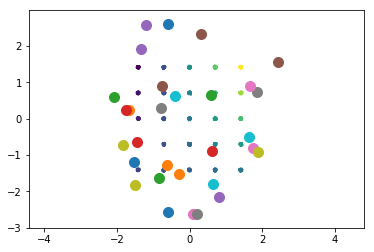

In [3]:
import numpy as np

x = np.reshape(x_org, (nb_data, 1, nb_dim))
mean = np.random.random((1, nb_mix, nb_dim)) * (xmax-xmin)*2. - (xmax-xmin)
cov = np.expand_dims(np.stack([np.eye(nb_dim)] * nb_mix), 0)
pi = np.random.random(nb_mix)
pi = pi / pi.sum()

resp = np.zeros((nb_data,nb_mix,1))
for k,p in enumerate(pi):
    pdf = pdf_gaussian(x[:,0,:], mean[0,k,:], cov[0,k,:,:])
    resp[:,k:k+1,:] += np.expand_dims(np.expand_dims(p * pdf, 1),1)
resp = resp / resp.sum(1, keepdims=True)

plt.scatter(x_org[:,0], x_org[:,1], c=y, s=1)
for m in mean[0]:
    plt.scatter(m[0], m[1], s=100)
plt.axes().set_aspect('equal', 'datalim')

In [4]:
def figshow(x_org, mean, cov, pi, save=False, header=None):
    xmax = x_org.max()
    xmin = x_org.min()
    nb_mix = len(pi)
    
    plt.figure(figsize=(10,5))

    xv, yv = np.meshgrid(np.linspace(xmin-(xmax-xmin)*0.5,xmax+(xmax-xmin)*0.5,100), np.linspace(xmin-(xmax-xmin)*0.5,xmax+(xmax-xmin)*0.5,100))
    samples = np.stack([xv,yv]).transpose(1,2,0).reshape(100*100,2)

    plt.subplot(1,2,1)
    plt.scatter(x_org[:,0], x_org[:,1], c='gray', s=1)
    for k in range(nb_mix):
        pdf = pdf_gaussian(np.expand_dims(samples,1), mean[0,k,:], cov[0,k,:,:])
        plt.contour(xv, yv, pdf.reshape((100,100)), cmap='Blues')

    pdf = 0.
    for k in range(nb_mix):
        pdf += pi[k]*pdf_gaussian(np.expand_dims(samples,1), mean[0,k,:], cov[0,k,:,:])

    plt.subplot(1,2,2)
    plt.scatter(x_org[:,0], x_org[:,1], c='gray', s=1)
    plt.contour(xv, yv, pdf.reshape((100,100)), cmap='Blues')
    
    if save:
        plt.savefig('gmm.'+header+'.'+str(epoch).zfill(4)+'.png', bbox_inches='tight', transparent=False)
        plt.close()
    else:
        plt.show()

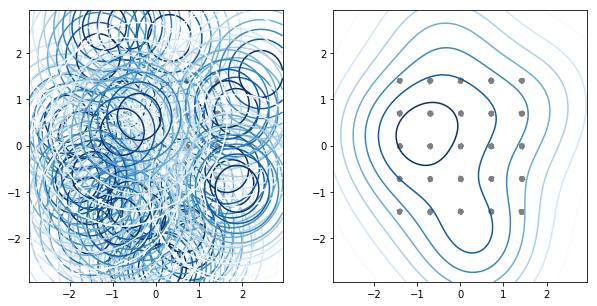

In [5]:
figshow(x_org, mean, cov, pi)

In [6]:
for epoch in range(100):
    figshow(x_org, mean, cov, pi, save=True, header=data)
        
    mean = (resp * x).sum(0, keepdims=True) / resp.sum(0, keepdims=True)
    cov = (np.expand_dims(resp, -1) * np.expand_dims((x-mean), -1) * np.expand_dims((x-mean), -2)).sum(0, keepdims=True) / np.expand_dims(resp, -1).sum(0, keepdims=True)

    resp = np.zeros((nb_data,nb_mix,1))
    for k,p in enumerate(pi):
        pdf = pdf_gaussian(x, mean[0,k,:], cov[0,k,:,:])
        resp[:,k:k+1,:] += np.expand_dims(p * pdf, 1)
    resp += np.finfo(np.float32).eps
    resp = resp / resp.sum(1, keepdims=True)
    
    pi = resp.sum(0) / float(nb_data)

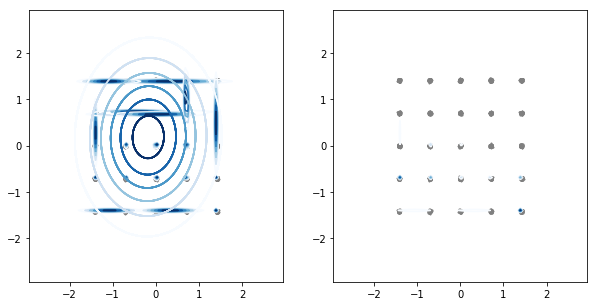

In [7]:
figshow(x_org, mean, cov, pi)